In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
# HS300 = list(ts.get_hs300s()['code'])
# HS300_df = pd.read_csv('../database/HS300IDX_ALL.csv')
# HS300 = list(set(HS300_df.con_code))
# HS300 = [x.split('.')[0] for x in HS300]
# ZZ500 = list(ts.get_zz500s()['code'])
# SZ50 = list(ts.get_sz50s()['code'])
# HSALL = list(set(ts.get_stock_basics().index) - set(['601162', '002940', '002939', '300674', '002941']))
# HSALL = HSALL + ['000866', '600001', '000956']

BENCHMARK = '399300'
# BENCHMARK = '163407'  # 兴全300(SZ:163407)
BENCHMARK = '000905'  # 中证500(SH:000905)
# BENCHMARK = '510300'  # 300ETF(SH:510300)
# BENCHMARK = '512880'  # 证券ETF(SH:512880)
# BENCHMARK = '511220'  # 城投ETF(SH:511220)

TARGET = ['399300']
# TARGET = ['163407']
TARGET = ['000905']
# TARGET = ['510300']
# TARGET = ['512880']
# TARGET = ['511220']

ALL_TARGET = TARGET[:]
len(ALL_TARGET)

pd

# df = pro.fund_daily(ts_code='163407.SZ', start_date='20110101', end_date='20150101')

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

#         if symbol.startswith('00') or symbol.startswith('30'):
#             temp_symbol = '%s.SZ' % symbol
#         elif symbol.startswith('60'):
#             temp_symbol = '%s.SH' % symbol
#         df = pro.daily_basic(ts_code=temp_symbol, start_date='20050101', end=time.strftime('%Y%m%d'))
#         datafile = '../database/market/%s_pro_daily_basic.csv' % symbol
#         df.to_csv(datafile, index=False, encoding='utf-8')
        
#     print(datafile)
    time.sleep(1)

000905
000905
Wall time: 3.34 s


In [3]:
%%time

### 时间设置
start_date = '2009-01-01'
end_date = '2019-03-01'
# end_date = time.strftime('%Y-%m-%d')

TURTLE_POS = 1
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 30
TURTLE_LONG_SELL_N = 20

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = True
IS_FILTER = False
IS_MARKETUP = False
IS_UNIQUE = False
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK] + ['163407']:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['pre_close'] = stock_df.close.shift(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.pre_close) / stock_df.pre_close
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
#     stock_df['MA250'] = stock_df['open'].rolling(250).mean()
    stock_df['MA120'] = stock_df['open'].rolling(120).mean()
    stock_df['MA90'] = stock_df['open'].rolling(90).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    stock_df['MA10'] = stock_df['open'].rolling(10).mean()
    
#     df = '../database/market/%s_pro_daily_basic.csv' % symbol
#     try:
#         df = pd.read_csv(df)
#         df = df[::-1]
#         df = df.assign(trade_date=pd.to_datetime(df['trade_date'], format='%Y%m%d'))
#         df.set_index(['trade_date'], inplace=True)
#         df.index = df.index.to_period('D')
#         stock_df = pd.concat([stock_df, df['pe']], axis=1)
#     except:
#         print(symbol)
#         stock_df['pe'] = 9999
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 64 ms


In [5]:
'''抽查数据'''

stock_df_dict[BENCHMARK].head(2)
stock_df_dict[BENCHMARK].tail(2)

df = stock_df_dict[BENCHMARK].iloc[:].copy()
df.columns
df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index('date', inplace=True)
# ax = df.plot(kind='line', y='close', label='test', linewidth=1, grid=True)
display_charts(df, chart_type='stock', kind='line', 
               y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N, 'MA30', 'MA60', 'MA180'], 
#                y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N],
#                y=['open', 'MA10', 'MA30', 'MA60', 'MA90', 'MA180'],
               figsize=(900, 600))

'抽查数据'

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_30_MAX,ROLLING_20_MIN,MA120,MA90,MA60,MA30,MA10
date,,,,,,,,,,,
2007-07-13,3671.46,3655.84,0.003296,0.000076,4539.58,3359.09,3282.49550,3623.228333,3990.331000,3918.541,3612.568
2007-07-16,3654.86,3532.06,-0.004521,-0.000268,4539.58,3359.09,3297.27375,3635.966889,3995.199833,3910.310,3620.882


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_30_MAX,ROLLING_20_MIN,MA120,MA90,MA60,MA30,MA10
date,,,,,,,,,,,
2019-03-06,5328.13,5390.03,0.035268,0.006202,5328.13,4189.11,4472.366333,4430.835667,4444.3205,4585.097000,4989.740
2019-03-07,5381.23,5458.62,0.009966,-0.001633,5381.23,4189.11,4477.140083,4442.444333,4458.9035,4619.983667,5061.235


Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA120', 'MA90', 'MA60', 'MA30', 'MA10'],
      dtype='object')

In [6]:
%matplotlib inline
import stockstats
stockstats
from stockstats import StockDataFrame
StockDataFrame.BOLL_PERIOD = 20
StockDataFrame.BOLL_STD_TIMES = 2

stock = stock_df_dict[BENCHMARK].copy()
stock = StockDataFrame.retype(stock)
# stock.get('macd')
# stock.get('change')
b = stock.get('boll')
# stock

stock_df_dict[BENCHMARK]['boll_ub'] = stock['boll_ub']
stock_df_dict[BENCHMARK]['boll_lb'] = stock['boll_lb']
# stock_df_dict[BENCHMARK]

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = stock.copy()
df = df.iloc[:]
# df.drop(columns=['PROPERTY'], inplace=True)
df.columns
df = df.dropna(how='any', inplace=False)
df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index('date', inplace=True)
# df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
# ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
# ax = df.plot(kind='line', y='boll', linewidth=1, grid=True, ax=ax)
# ax = df.plot(kind='line', y='boll_ub', linewidth=1, grid=True, ax=ax)
# ax = df.plot(kind='line', y='boll_lb', linewidth=1, grid=True, ax=ax)

display_charts(df, chart_type='stock', kind='line', 
               y=['close', 'boll', 'boll_ub', 'boll_lb',], 
               figsize=(900, 600))

<module 'stockstats' from 'd:\\python36\\lib\\site-packages\\stockstats.py'>

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'rolling_30_max',
       'rolling_20_min', 'ma120', 'ma90', 'ma60', 'ma30', 'ma10',
       'close_20_sma', 'close_20_mstd', 'boll', 'boll_ub', 'boll_lb'],
      dtype='object')

In [7]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

'用基准数据来存储策略数据'

In [8]:
# %%time
# # %xmode

# '''布林带'''

# PROPERTY = START_MONEY
# CASH = START_MONEY
# IS_MARKETUP = False
# IS_RANDOM_BUY = True
# count_day = 0
# yesterday = None
# miss_buy_short = 0
# miss_buy_long = 0
# # TARGET = []

# order_df = None
# order_df = pd.DataFrame(columns=[
#     'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
# ])

# ops_df = None
# ops_df = pd.DataFrame(columns=[
#     'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
# ])

# # 时间序列
# for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     count_day += 1
    
#     # 每年年初计算回报率
#     if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
#         if today.dayofyear == 1:
#             lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
#         else:
#             lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
#         lastyear_firstday = lastyear_firstday.to_period(freq='D')
# #         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
#         if today > show_df.iloc[0].name:
#             today_property = show_df[:today].iloc[-2].PROPERTY
# #             print(show_df[:today].iloc[-1])
#         else:
#             today_property = show_df.iloc[0].PROPERTY
#         if lastyear_firstday > show_df.iloc[0].name:
#             lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
#         else:
#             lastyear_firstday_property = show_df.iloc[0].PROPERTY
# #         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
#         lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
#         print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)

        
    
#     if yesterday is None:
#         yesterday = today
#         continue

#     # 日期不在基准交易日，则不交易
#     if today not in stock_df_dict[BENCHMARK].index:
#         continue
    
#     # 突破下行趋势，清仓退出
#     order_arr = order_df.to_records(index=False)
#     if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
#         is_sell = False
#         for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
#             cur_order = order_df.loc[idx]
#             symbol = cur_order['symbol']
#             if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
#                 continue
#             today_market = stock_df_dict[symbol].loc[today]
#             if today_market.c_o_pct_chg < -0.1:
# #                 print(today, symbol, '跌停板，卖不掉')
#                 continue
#             if cur_order.buy_reason == 'SHORT':
#                 is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
#             if cur_order.buy_reason == 'LONG':
#                 is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
#             if is_sell:
#                 CASH += cur_order.buy_count * today_market.open
#                 order_df.loc[idx, 'sell_date'] = today
#                 order_df.loc[idx, 'sell_price'] = today_market.open
#                 order_df.loc[idx, 'sell_reason'] = 'EXIT'
#                 order_df.loc[idx, 'profit'] = \
#                     (today_market.open - cur_order.buy_price) * cur_order.buy_count
# #                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
#                 ops_df = ops_df.append(
#                     {
#                         'ops_date': today,
#                         'ops': 'SELL',
#                         'symbol': symbol,
#                         'count': cur_order.buy_count,
#                         'price': today_market.open,
#                         'reason': cur_order.buy_reason,
#                         'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
#                     },
#                     ignore_index=True
#                 )

#     # 开心止盈，倍数止盈
#     if IS_HAPPYMONEY:        
#         if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
#             HAPPY_MONEY += START_MONEY
#             PROPERTY -= START_MONEY
#             CASH -= START_MONEY
    
#     benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     buy_list = []
    
#     # 遍历标的，判断和执行买入
#     for symbol in TARGET:
#         if symbol not in stock_df_dict:
#             continue

#         # 趋势交易，只在好行情时买入
#         if IS_MARKETUP:
#             if benchmark_today_market.MA60 < benchmark_today_market.MA180:
# #             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
#                 break
        
#         # 是否购买基准
#         if not IS_BUYBENCHMARK and symbol == BENCHMARK:
#             continue
        
#         if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
#             continue
            
#         # TIME TEST
#         # DELETED
        
#         today_market = stock_df_dict[symbol].loc[today]

#         # 突破上行趋势，就买一份
# #         order_arr = order_df.to_records(index=False)
#         is_buy = False
#         if True:
#             if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
#                 is_buy = True
#                 buy_reason = 'LONG'
#             elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
#                 is_buy = True
#                 buy_reason = 'SHORT'

#         if is_buy:
#             buy_list.append(symbol)
            
#     if IS_RANDOM_BUY:
#         random.shuffle(buy_list)
#     else:
#         tmp_list = []
#         for symbol in buy_list:
#             try:
#                 return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
#             except:
#                 return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
# #             tmp_list.append((return_lastyear, symbol))
#             try:
#                 pe = stock_df_dict[symbol][:today].iloc[-1].pe
#             except:
#                 pe = 9999
#             tmp_list.append((pe, symbol))
#         tmp_list = sorted(tmp_list, reverse=False)
# #         buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
# #         random.shuffle(buy_list)
    
#     for symbol in buy_list:    
#         if IS_UNIQUE:
#             if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
#                 continue
#         today_market = stock_df_dict[symbol].loc[today]
#         buy_count = 0
                
#         # 滑点
#         if IS_SLIPPAGE:
#             buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
#         else:
#             buy_price = today_market.open
                
#         # 按份数买
#         if CASH >= PROPERTY / TURTLE_POS:
#             buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

#         # 指数购买，满仓干
# #         buy_count = int(CASH / buy_price)

#         if buy_count > 0:
#             if today_market.c_o_pct_chg > 0.1:
# #                 print(today, symbol, '涨停板，买不进')
#                 continue
            
#         if buy_count > 0:
#             CASH -= buy_count * buy_price
# #             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
#             order_df = order_df.append(
#                 {
#                     'buy_date': today,
#                     'symbol': symbol,
#                     'buy_count': buy_count,
#                     'buy_price': today_market.open,
#                     'buy_reason': buy_reason,
#                     'sell_date': pd.np.nan,
#                     'sell_price': 0,
#                     'profit': 0,
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )
#             ops_df = ops_df.append(
#                 {
#                     'ops_date': today,
#                     'ops': 'BUY',
#                     'symbol': symbol,
#                     'count': buy_count,
#                     'price': buy_price,
#                     'reason': buy_reason,
#                     'profit': 0,
#                 },
#                 ignore_index=True
#             )
#         else:
#             if buy_reason == 'LONG':
#                 miss_buy_long += 1
#             elif buy_reason == 'SHORT':
#                 miss_buy_short += 1
            
#     # 每天盘点财产
#     # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
# #     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
# #         CASH = CASH * (1 + 0.04 / 365)
#     CASH = CASH * (1 + 0.03 / 365)
#     show_df.loc[today, 'CASH'] = CASH
#     PROPERTY = CASH + \
#         sum(
#             [
#                 stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
#                 for idx in order_df.loc[order_df['sell_price']==0].index
#             ]
#         )
#     show_df.loc[today, 'PROPERTY'] = PROPERTY

#     yesterday = today

    
# # 最后一天，清仓
# order_arr = order_df.to_records(index=False)
# for idx in order_df[order_df['sell_price'] == 0].index:
#     cur_order = order_df.loc[idx]
#     symbol = cur_order['symbol']
#     today_market = stock_df_dict[symbol][:today].iloc[-1]
#     CASH += cur_order.buy_count * today_market.open
#     order_df.loc[idx, 'sell_date'] = today
#     order_df.loc[idx, 'sell_price'] = today_market.open
#     order_df.loc[idx, 'sell_reason'] = 'EXIT'
#     order_df.loc[idx, 'profit'] = \
#         (today_market.open - cur_order.buy_price) * cur_order.buy_count
#     ops_df = ops_df.append(
#         {
#             'ops_date': today,
#             'ops': 'SELL',
#             'symbol': symbol,
#             'count': cur_order.buy_count,
#             'price': today_market.open,
#             'reason': cur_order.buy_reason,
#             'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
#         },
#         ignore_index=True
#     )


# print('START_MONEY', START_MONEY)
# print('CASH', CASH)
# print('HAPPY_MONEY', HAPPY_MONEY)
# print('PROPERTY', PROPERTY)

# s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
# e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
# print('BENCHMARK', s_p, e_p, e_p / s_p)

# show_df['PROPERTY_TT'] = show_df['PROPERTY']

In [9]:
%%time
# %xmode

'''简易海龟策略，唐安奇通道突破信号，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = True
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0
# TARGET = []

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
#     # 更新指数成分
#     if BENCHMARK == '399300':
#         HS300_NEW = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
#         if len(HS300_NEW) == 300:
#             HS300_NEW = [x.split('.')[0] for x in list(HS300_NEW.con_code)]
#             if sorted(HS300_NEW) != sorted(HS300):
#                 print(today, 'CHANGE HS300', len(HS300_NEW))
#                 HS300 = HS300_NEW
#         else:
#             pass

    
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue

        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED
        
        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
#         order_arr = order_df.to_records(index=False)
        is_buy = False
        if True:
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
#             tmp_list.append((return_lastyear, symbol))
            try:
                pe = stock_df_dict[symbol][:today].iloc[-1].pe
            except:
                pe = 9999
            tmp_list.append((pe, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         buy_list = [x[1] for x in tmp_list if x[0]>1]
        buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue
        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today

    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_TT'] = show_df['PROPERTY']

2008-01-01 2009-01-01 100000 100000 0.000
2009-01-01 2010-01-01 100000 183286 0.833
2010-01-01 2011-01-01 183301 183262 -0.000
2011-01-01 2012-01-01 183277 167701 -0.085
2012-01-01 2013-01-01 167714 178430 0.064
2013-01-01 2014-01-01 181057 194165 0.072
2014-01-01 2015-01-01 194181 265553 0.368
2015-01-01 2016-01-01 261499 423304 0.619
2016-01-01 2017-01-01 423339 406914 -0.039
2017-01-01 2018-01-01 406947 391778 -0.037
2018-01-01 2019-01-01 391810 357443 -0.088
2019-01-01 2019-03-01 357472 408319 0.142
START_MONEY 100000
CASH 410732.5704673104
HAPPY_MONEY 0
PROPERTY 410732.5704673104
BENCHMARK 1969.63 5047.23 2.5625269720708963
Wall time: 6.53 s


In [10]:
order_df
ops_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2009-01-19,000905,45,2209.130,LONG,2009-08-13,3772.67,EXIT,70359.3,671.372187,100082.222187
1,2009-10-26,000905,43,3914.610,LONG,2009-12-21,4195.12,EXIT,12061.9,2766.637462,171094.867462
2,2010-01-15,000905,38,4720.217,LONG,2010-01-27,4290.74,EXIT,-16320.3,4068.836430,183437.082430
3,2010-04-02,000905,34,4833.810,LONG,2010-04-30,4540.65,EXIT,-9967.37,3347.819316,167697.359316
4,2010-07-29,000905,38,4170.762,LONG,2010-12-28,4820.82,EXIT,24702.2,26.024676,158514.980676
5,2011-02-22,000905,36,5052.360,LONG,2011-04-01,4999.76,EXIT,-1893.6,1845.139209,183730.099209
6,2011-07-05,000905,38,4722.330,LONG,2011-08-03,4565.75,EXIT,-5950.04,3336.199747,182784.739747
7,2011-11-15,000905,42,4159.160,LONG,2011-11-24,3909.39,EXIT,-10490.3,3146.837795,177831.557795
8,2012-02-10,000905,48,3463.970,LONG,2012-03-26,3661.39,EXIT,9476.16,1747.756769,168018.316769
9,2012-05-08,000905,47,3783.080,LONG,2012-05-21,3650.92,EXIT,-6211.52,73.878207,177878.638207


,ops_date,ops,symbol,count,price,reason,profit
0,2009-01-19,BUY,000905,45,2209.130,LONG,0
1,2009-08-13,SELL,000905,45,3772.670,LONG,70359.3
2,2009-10-26,BUY,000905,43,3914.610,LONG,0
3,2009-12-21,SELL,000905,43,4195.120,LONG,12061.9
4,2010-01-15,BUY,000905,38,4720.217,LONG,0
5,2010-01-27,SELL,000905,38,4290.736,LONG,-16320.3
6,2010-04-02,BUY,000905,34,4833.810,LONG,0
7,2010-04-30,SELL,000905,34,4540.652,LONG,-9967.37
8,2010-07-29,BUY,000905,38,4170.762,LONG,0
9,2010-12-28,SELL,000905,38,4820.820,LONG,24702.2


In [11]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

START                2009-01-01
END                  2019-03-01
TURTLE_POS                    1
ROLLMAX                       0
ROLLMIN                       0
MA_SHORT                     60
MA_LONG                     180
X_DAY_RETURN                250
ORDER                        29
STOCK                         1
RETURN                  3.10699
MAXDROPDOWN           -0.374956
WINRATE                 0.37931
annual_return            0.1551
annual_volatility      0.187181
calmar_ratio           0.413649
sharpe_ratio           0.865256
alpha                  0.107076
beta                   0.385185
ALL_DAYS                   2469
FREECASH_DAY                  0
MISS_SIGNAL                 360
RET_PER_YEAR                   
dtype: object

In [12]:
%%time
# %xmode

'''均线突破策略，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = True
IS_UNIQUE = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
        
#     # 更新指数成分
#     if BENCHMARK == '399300':
#         NEW_TARGET_df = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
#         if len(NEW_TARGET_df) != 0:
#             NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
#             if sorted(NEW_TARGET) != sorted(TARGET):
#                 print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
#                 TARGET = NEW_TARGET
#         else:
#             pass
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
#                 is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
#                 is_sell = (today_market.MA10 <= today_market.MA60)
                is_sell = (today_market.MA90 < today_market.MA120)
#                 is_sell = (today_market.MA180 <= today_market.MA250)
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue
        
        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA250:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA360:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA250 and benchmark_today_market.MA180 < benchmark_today_market.MA250:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]
        yesterday_market = stock_df_dict[symbol].loc[:today].iloc[-2]

        # 突破上行趋势，就买一份
        is_buy = False
        if True:
#             if today_market.MA90 >= today_market.MA180 and yesterday_market.MA90 <= yesterday_market.MA180:
#             if today_market.MA10 >= today_market.MA60:
            if today_market.MA90 >= today_market.MA120:
#             if today_market.MA180 > today_market.MA250:
                is_buy = True
                buy_reason = 'LONG'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            lastyear_today = pd.to_datetime('%d-%d-01' % (today.year - 1, today.month))
            if len(stock_df_dict[symbol][lastyear_today:today]) < 100:
#                 print('%s %d 停牌' % (symbol, len(stock_df_dict[symbol][lastyear_today:today])))
#                 continue
                pass
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         print(today, tmp_list)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)
    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_MA'] = show_df['PROPERTY']

2008-01-01 2009-01-01 100000 100000 0.000
2009-01-01 2010-01-01 100000 187392 0.874
2010-01-01 2011-01-01 186742 166488 -0.108
2011-01-01 2012-01-01 167285 198785 0.188
2012-01-01 2013-01-01 198801 181968 -0.085
2013-01-01 2014-01-01 181983 193907 0.066
2014-01-01 2015-01-01 193408 250043 0.293
2015-01-01 2016-01-01 246237 286576 0.164
2016-01-01 2017-01-01 286599 296921 0.036
2017-01-01 2018-01-01 296627 295770 -0.003
2018-01-01 2019-01-01 297533 307803 0.035
2019-01-01 2019-03-01 307828 308766 0.003
START_MONEY 100000
CASH 308791.62900922535
HAPPY_MONEY 0
PROPERTY 308791.62900922535
BENCHMARK 1969.63 5047.23 2.5625269720708963
Wall time: 7.47 s


In [13]:
order_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2009-03-02,000905,42,2385.84,LONG,2010-06-07,4000.65,EXIT,67822,82.793548,100288.073548
1,2010-10-25,000905,34,4894.85,LONG,2011-03-29,5185.68,EXIT,9888.22,2921.554583,169346.454583
2,2011-06-13,000905,40,4439.87,LONG,2011-07-20,4864.28,EXIT,16976.4,2403.366395,179998.166395
3,2012-05-24,000905,54,3697.92,LONG,2012-07-26,3329.01,EXIT,-19921.1,606.255944,200293.935944
4,2013-02-27,000905,51,3538.94,LONG,2013-07-22,3374.57,EXIT,-8382.87,1991.498244,182477.438244
5,2013-08-21,000905,48,3596.93,LONG,2013-10-25,3902.23,EXIT,14654.4,1772.639737,174425.279737
6,2013-11-07,000905,50,3722.24,LONG,2014-03-03,3975.54,EXIT,12665,3113.434417,189225.434417
7,2014-03-25,000905,50,3977.88,LONG,2014-07-04,4018.39,EXIT,2025.5,3281.631931,202175.631931
8,2014-08-15,000905,46,4372.77,LONG,2015-09-28,6118.23,EXIT,80291.2,3576.531182,204723.951182
9,2016-02-04,000905,50,5631.32,LONG,2016-03-18,5774.3,EXIT,7149,5576.121835,287142.121835


In [14]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

START                2009-01-01
END                  2019-03-01
TURTLE_POS                    1
ROLLMAX                       0
ROLLMIN                       0
MA_SHORT                     60
MA_LONG                     180
X_DAY_RETURN                250
ORDER                        12
STOCK                         1
RETURN                  2.08766
MAXDROPDOWN           -0.502785
WINRATE                    0.75
annual_return          0.121952
annual_volatility      0.233163
calmar_ratio           0.242553
sharpe_ratio            0.61212
alpha                 0.0574681
beta                    0.59835
ALL_DAYS                   2469
FREECASH_DAY                  0
MISS_SIGNAL                1301
RET_PER_YEAR                   
dtype: object

In [15]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

'计算标的持有、收益等'

,pro_pct
symbol,
000905,1.283376


,pro_pct
symbol,
000905,1.283376


1

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA120', 'MA90', 'MA60', 'MA30', 'MA10', 'boll_ub',
       'boll_lb', 'CASH', 'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')

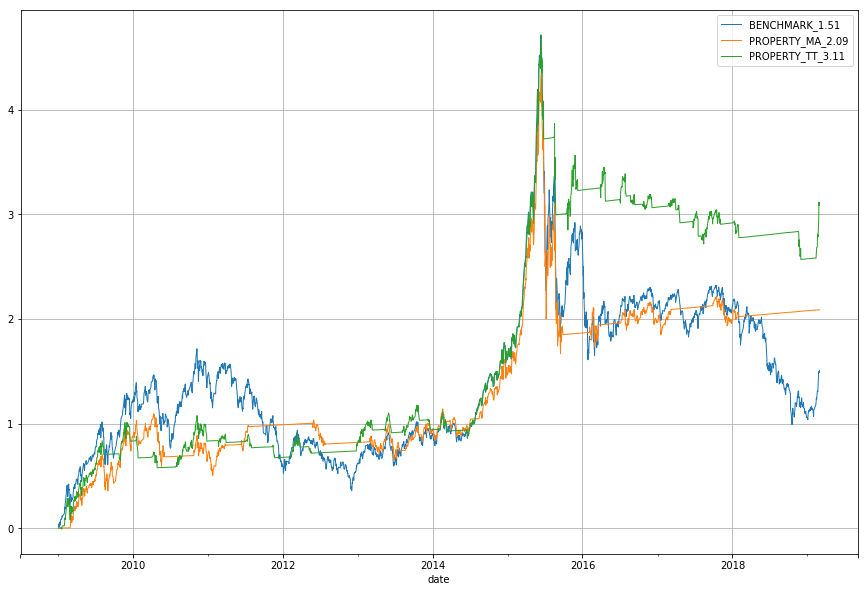

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df['PROPERTY_ETF'] = stock_df_dict['163407']['open']
# stock_df_dict['163407']
# df
df.columns
# df.index
# df
df = df.dropna(how='any', inplace=False)

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
# for col in sorted(df.columns):
#     if 'PROPERTY' in col:
#         df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
#         ax = df.plot(kind='line', y=col, secondary_y=False, label='MA_%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [17]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df.drop(columns=['PROPERTY_TT'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)
#     if 'CASH' in col:
#         df[col] = df[col] / df.iloc[0][col]
#         show_columns.append(col)
        
# df['unused'] = df['CASH'] / df['PROPERTY_TT']
# df = df.loc['20070101':]
# show_columns = ['unused']
# show_columns.append('unused')

df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

# display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA120', 'MA90', 'MA60', 'MA30', 'MA10', 'boll_ub',
       'boll_lb', 'CASH', 'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')